# Data Science Classification Project: Classify Celebrity Images

In this project, I will predict the celebrity based on the image data using opencv.

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# 1. Preprocessing
## 1.1 Detect face and eyes

When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.

I have used haar cascade from opencv for this. Here is an article on this: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar


In [2]:
img = cv2.imread('./test_images/CristianoRonaldo.jpg')
img.shape

(921, 614, 3)

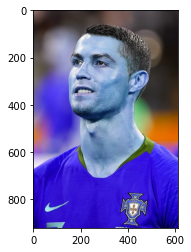

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(921, 614)

In [5]:
gray

array([[123, 123, 123, ...,  45,  45,  46],
       [123, 123, 122, ...,  45,  45,  46],
       [123, 122, 121, ...,  44,  45,  45],
       ...,
       [ 18,  18,  21, ...,  41,  44,  47],
       [ 16,  16,  19, ...,  40,  45,  49],
       [ 17,  15,  17, ...,  43,  52,  59]], dtype=uint8)

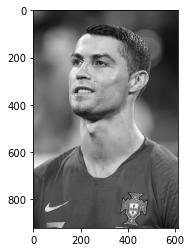

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 53,  69, 361, 361]], dtype=int32)

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(53, 69, 361, 361)

#### face_img will show the position that the opencv has captured using the face cascade and point it out with red boxes.

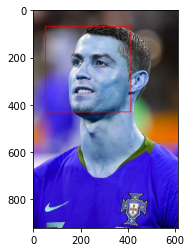

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

#### Next, we will use eye cascade to identify any eyes that are within the image and point it out with green boxes.

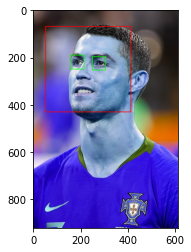

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w] #roi: region of interest
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

## 1.2 Preprocessing: Crop the facial region of the image

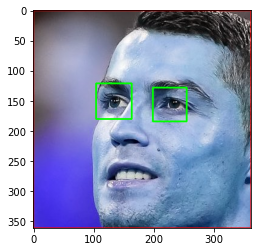

In [11]:
plt.imshow(roi_color, cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(361, 361, 3)


## 1.3 Preprocessing: Use wavelet transform as a feature for training the model
In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc
## Wavelet transform

In [13]:
import pywt   

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

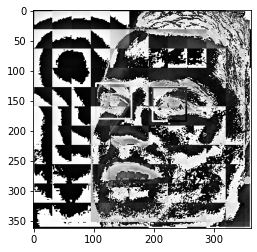

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')


## 1.4 Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region
This take input image and returns cropped image (if face and eyes >=2 are detected)

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [16]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if(img is not None):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color   

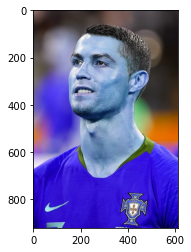

In [17]:
original_image = cv2.imread('./test_images/CristianoRonaldo.jpg')
plt.imshow(original_image)

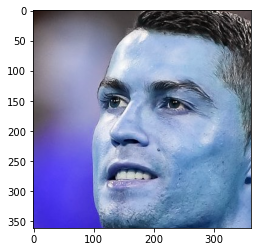

In [18]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/CristianoRonaldo.jpg')
plt.imshow(cropped_image)

#### In below image face is not very clear and it doesn't have two eyes clearly visible

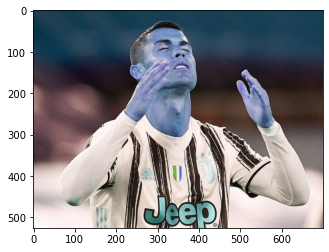

In [19]:
org_image_obstructed = cv2.imread('./test_images/CristianoRonaldo1.jpg')
plt.imshow(org_image_obstructed)

In [20]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/CristianoRonaldo1.jpg')
cropped_image_no_2_eyes

#### Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training

In [21]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [22]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [23]:
img_dirs

['./dataset/christiano_ronaldo',
 './dataset/cropped',
 './dataset/emma_watson',
 './dataset/iu',
 './dataset/lionel_messi',
 './dataset/tiger_woods']

#### Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after running this code

In [24]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data) #remove path if exist so that everytime run the code it will be no errors
os.mkdir(path_to_cr_data)

In [25]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/christiano_ronaldo
Generating cropped images in folder:  ./dataset/cropped/emma_watson
Generating cropped images in folder:  ./dataset/cropped/iu
Generating cropped images in folder:  ./dataset/cropped/lionel_messi
Generating cropped images in folder:  ./dataset/cropped/tiger_woods


## 1.5 Preprocessing: Manually examine cropped folder and delete any unwanted images

In [26]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

In [27]:
celebrity_file_names_dict

{'christiano_ronaldo': ['./dataset/cropped/christiano_ronaldo\\christiano_ronaldo10.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo11.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo12.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo13.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo14.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo15.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo16.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo17.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo18.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo19.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo2.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo20.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo21.png',
  './dataset/cropped/christiano_ronaldo\\christiano_ronaldo22.png',
  './dataset/cropped/christ

In [28]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'christiano_ronaldo': 0,
 'emma_watson': 1,
 'iu': 2,
 'lionel_messi': 3,
 'tiger_woods': 4}

# 2. Prepare the data for Machine Learning Algorithms

Images in cropped folder can be used for model training. I used these raw images along with wavelet transformed images to train the classifier.

In [29]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [30]:
len(X[0])

4096

In [31]:
X[0]

array([[4],
       [3],
       [5],
       ...,
       [1],
       [1],
       [4]], dtype=uint8)

In [32]:
y[0]

0

In [33]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(255, 4096)

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 3.  Select and Train Models

In [80]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [81]:
def get_accuracy(model):
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pipe.fit(X_train, y_train)
    print(str(model) + " Accuracy:" + str(pipe.score(X_test, y_test)))
    print(classification_report(y_test, pipe.predict(X_test)))

## 3.1 Support Vector Machine (SVM)

In [82]:
get_accuracy(SVC())

SVC() Accuracy:0.828125
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.77      1.00      0.87        20
           2       0.90      0.79      0.84        24
           3       0.88      0.78      0.82         9
           4       1.00      1.00      1.00         1

    accuracy                           0.83        64
   macro avg       0.86      0.83      0.84        64
weighted avg       0.84      0.83      0.82        64



## 3.2 Random Forest Classifier

In [83]:
get_accuracy(RandomForestClassifier())

RandomForestClassifier() Accuracy:0.84375
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.94      0.85      0.89        20
           2       0.92      0.92      0.92        24
           3       0.88      0.78      0.82         9
           4       1.00      1.00      1.00         1

    accuracy                           0.84        64
   macro avg       0.85      0.85      0.85        64
weighted avg       0.86      0.84      0.85        64



## 3.3 Logistic Regression

In [84]:
get_accuracy(LogisticRegression())

LogisticRegression() Accuracy:0.890625
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.90      0.95      0.93        20
           2       0.96      0.92      0.94        24
           3       0.75      1.00      0.86         9
           4       1.00      1.00      1.00         1

    accuracy                           0.89        64
   macro avg       0.89      0.89      0.89        64
weighted avg       0.90      0.89      0.89        64



D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 4. Fine-tune & Evaluate the models

I will use GridSearchCV to get the best parameters for each models and run the algorithm again with the new model and see if the accuracy changes for the models.

In [85]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [86]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [87]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=10, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.890000,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.738158,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.853158,{'logisticregression__C': 1}


In [88]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [89]:
best_estimators['svm'].score(X_test,y_test)

0.890625

In [90]:
best_estimators['random_forest'].score(X_test,y_test)

0.75

In [91]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.90625

**Despite the Logistic Regression model have a slightly higher score than the Support Vector Machine model, the SVM model outperforms during the cross validation score and hence, I will use the SVM model for my application.**

In [92]:
best_clf = best_estimators['svm']

In [93]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 8,  0,  1,  1,  0],
       [ 1, 18,  1,  0,  0],
       [ 1,  1, 22,  0,  0],
       [ 1,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  1]], dtype=int64)

Text(69.0, 0.5, 'Truth')

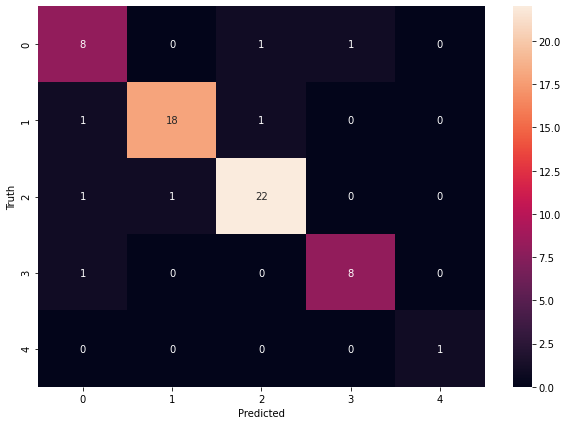

In [94]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [78]:
class_dict

{'christiano_ronaldo': 0,
 'emma_watson': 1,
 'iu': 2,
 'lionel_messi': 3,
 'tiger_woods': 4}

# 5. Deployment

## 5.1 Export the tested model using joblib into a pickle file

In [96]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

## 5.2 Save Class Dictionary to JSON file

In [97]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))